# FIR Filter using Scipy

This notebook demonstrates how to build a simple low-pass FIR filter that was used on simulated signals.  FIR filters have a linear phase shift wrt frequency.  The time base signal is shifted by a constant value and features (such as peaks) of the original and the filtered can be aligned.

For reference:  https://scipy.github.io/old-wiki/pages/Cookbook/FIRFilter.html

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
raw_data   = np.genfromtxt("./data/withoutnoise.txt", delimiter=',')
noisy_data = np.genfromtxt("./data/withnoise.txt", delimiter=',')

In [3]:
SamplingRate = 100.0

label_x_axis = "Time [s]"
label_y_axis = "Signal"

In [4]:
t = np.arange(raw_data.shape[0]) / 100
x = raw_data[:,1]
y = raw_data[:,2]
z = raw_data[:,3]

x_n = noisy_data[:,1]
y_n = noisy_data[:,2]
z_n = noisy_data[:,3]

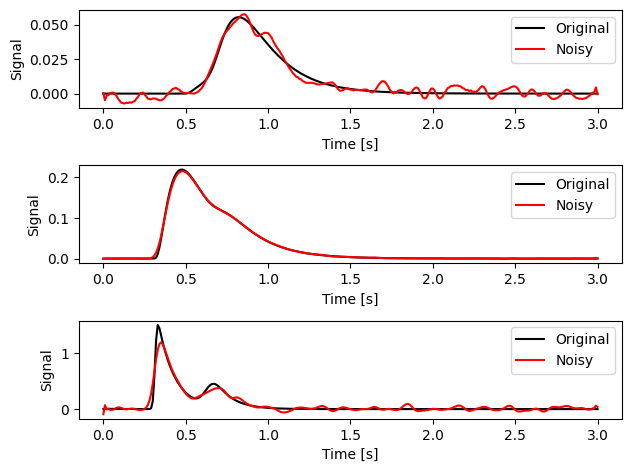

In [5]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(t, x, 'black', label='Original')
axs[0].plot(t, x_n, 'red', label='Noisy')
axs[0].set_xlabel(label_x_axis)
axs[0].set_ylabel(label_y_axis)
axs[0].legend()

axs[1].plot(t, y, 'black', label='Original')
axs[1].plot(t, y_n, 'red', label='Noisy')
axs[1].set_xlabel(label_x_axis)
axs[1].set_ylabel(label_y_axis)
axs[1].legend()

axs[2].plot(t, z, 'black', label='Original')
axs[2].plot(t, z_n, 'red', label='Noisy')
axs[2].set_xlabel(label_x_axis)
axs[2].set_ylabel(label_y_axis)
axs[2].legend()

fig.tight_layout(pad=1.0)
plt.show()

In [6]:
# Filter design is based on a set of criteria, such as cut-off frequencies, ripple, gain, etc
# I used the tool at http://t-filter.engineerjs.com to come up with a simple low-pass filter
# to obtain the number of taps.

# Filter was implemented using Scipy

# Number of Taps (for this notebook and subsequent calls, keep N as odd)
N = 63

H = signal.firwin2(N, [0.0, 3, 7, 50], [1, 1, 0, 0], fs=100)

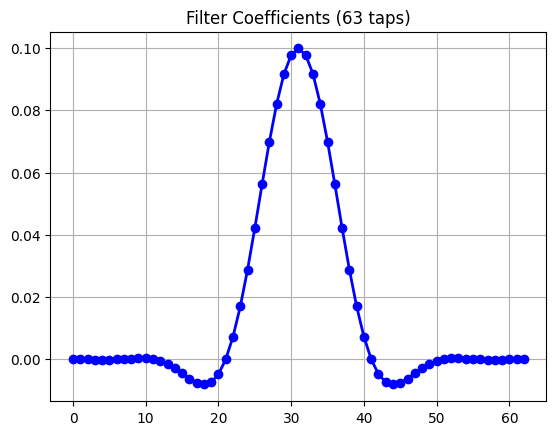

In [7]:
plt.plot(H, 'bo-', linewidth=2)
plt.title('Filter Coefficients ({} taps)'.format(N))
plt.grid(True)

In [8]:
# Code from https://scipy.github.io/old-wiki/pages/Cookbook/FIRFilter.html
def PlotFrequencyResponse(H, SamplingRate):
    w, h = signal.freqz(H, fs=SamplingRate, worN=512)
    
    plt.plot(w, np.abs(h), linewidth=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Frequency Response')

    plt.grid(True)
    
# Code from https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html
def PlotAmplitudeAndPhase(H, SamplingRate):
    w, h = signal.freqz(H, fs=SamplingRate, worN=512)
    
    fig, ax1 = plt.subplots()
    ax1.set_title('Digital Filter Frequency Response')
    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [Hz]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid(True)
    ax2.axis('tight')
    plt.show()

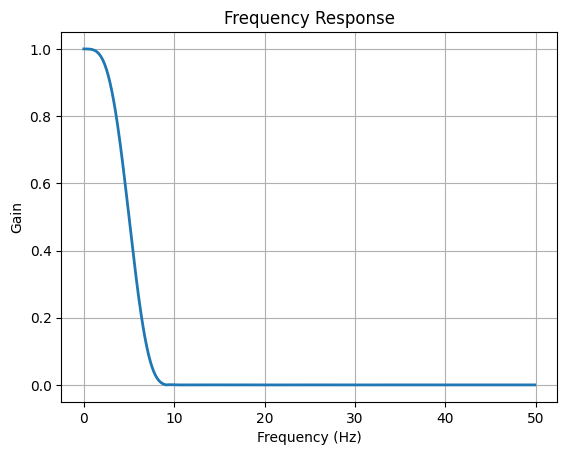

In [9]:
PlotFrequencyResponse(H, SamplingRate)

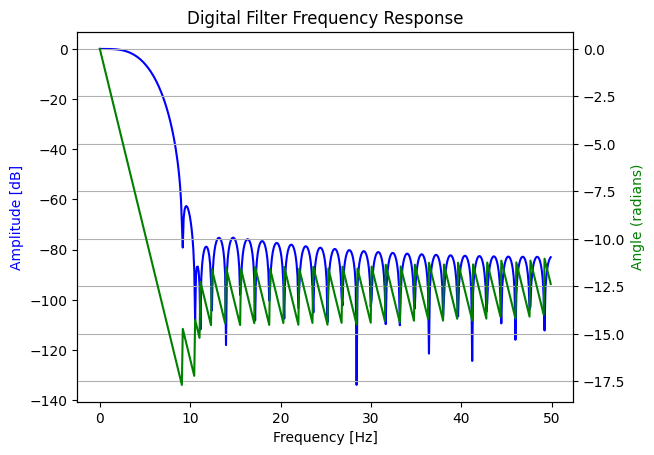

In [10]:
PlotAmplitudeAndPhase(H, SamplingRate)

In [11]:
filtered_x = signal.lfilter(H, 1.0, x_n)
filtered_y = signal.lfilter(H, 1.0, y_n)
filtered_z = signal.lfilter(H, 1.0, z_n)

In [12]:
# The phase delay of the filtered signal.
delay = 0.5 * (N - 1) / SamplingRate

In [13]:
def PlotGraphs(t, signal, signal_noisy, signal_filtered, N, delay):
    plt.figure(figsize=[10, 5])
    
    plt.plot(t, signal, 'black', label='Original')
    plt.plot(t, signal_noisy, 'red', label='Noisy')
    plt.plot(t, signal_filtered, 'blue', label='Filtered')
    plt.plot(t-delay, signal_filtered, 'green', label='Phase Corrected')
    plt.plot(t[N-1:]-delay, signal_filtered[N-1:], 'g', linewidth=3, label="Valid")
    
    plt.xlabel(label_x_axis)
    plt.ylabel(label_y_axis)

    plt.legend()
    plt.show()

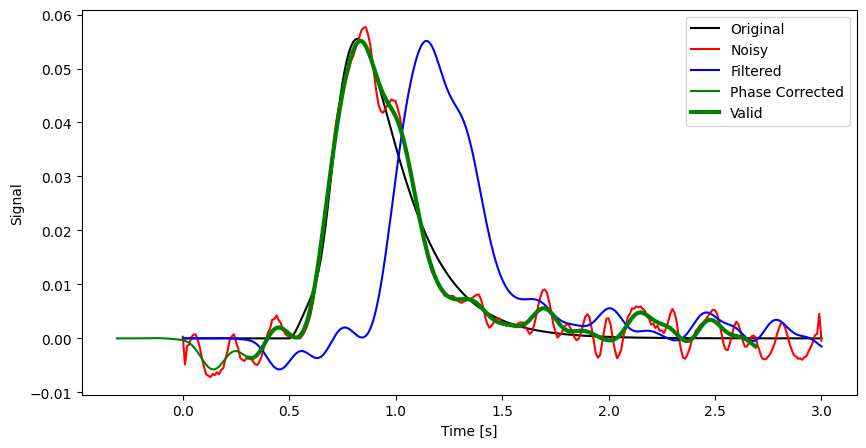

In [14]:
PlotGraphs(t, x, x_n, filtered_x, N, delay)

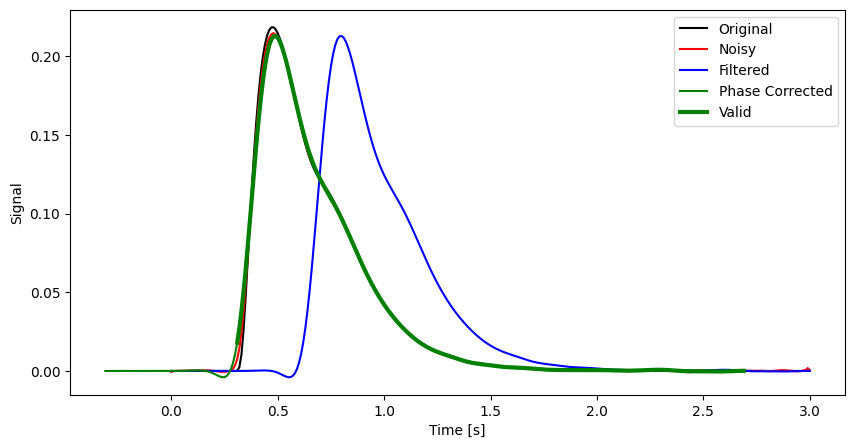

In [15]:
PlotGraphs(t, y, y_n, filtered_y, N, delay)

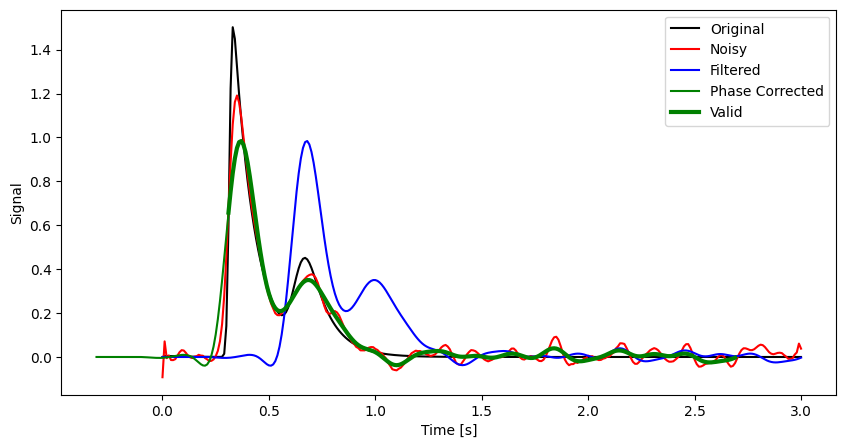

In [16]:
PlotGraphs(t, z, z_n, filtered_z, N, delay)

In [17]:
def GeneratePhaseCorrectedArray(signal_filtered, N):
    signal_phase_corrected = np.zeros(signal_filtered.shape)
    i = int((N - 1) / 2)
    
    signal_phase_corrected[i:-i] = signal_filtered[N-1:]
    
    return signal_phase_corrected

def SaveCSV(t, signal, signal_noisy, signal_filtered, signal_phase_corrected, filename, number_format="%.8f"):
    data = np.asarray([t, signal, signal_noisy, signal_filtered, signal_phase_corrected]).T
    np.savetxt(filename, data, delimiter=",", fmt=number_format)

In [18]:
SaveCSV(t, x, x_n, filtered_x, GeneratePhaseCorrectedArray(filtered_x, N), "X.CSV")
SaveCSV(t, y, y_n, filtered_y, GeneratePhaseCorrectedArray(filtered_y, N), "Y.CSV")
SaveCSV(t, z, z_n, filtered_z, GeneratePhaseCorrectedArray(filtered_z, N), "Z.CSV")